In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
from copy import deepcopy
import matplotlib as plt
import matplotlib.pyplot as plt
from  matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (16,6)
plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px
from scipy import stats
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import datetime as dt
import warnings
from sklearn.metrics import roc_curve, auc
warnings.filterwarnings("ignore")
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pivottablejs import pivot_ui

# Préparation des Données

In [3]:
data = pd.read_csv('Camp_Market_Updated2.csv')

print("Valeurs manquantes par colonne :")
print(data.isnull().sum())
print("\nNombre de doublons :", data.duplicated().sum())

data.drop_duplicates(inplace=True)

print("\nTypes de données :")
print(data.dtypes)

Valeurs manquantes par colonne :
Income                    0
Recency                   0
MntWines                  0
MntFruits                 0
MntMeatProducts           0
MntFishProducts           0
MntSweetProducts          0
MntGoldProds              0
NumDealsPurchases         0
NumWebPurchases           0
NumCatalogPurchases       0
NumStorePurchases         0
NumWebVisitsMonth         0
AcceptedThirdCampaign     0
AcceptedFourthCampaign    0
AcceptedFifthCampaign     0
AcceptedFirstCampaign     0
AcceptedSecondCampaign    0
Complain                  0
Z_CostContact             0
Z_Revenue                 0
AcceptedLastCampaign      0
AcceptedCampaign          0
Age                       0
Total_Spent               0
Children                  0
living_with               0
family_size               0
is_parent                 0
education2                0
customer_for              0
dtype: int64

Nombre de doublons : 185

Types de données :
Income                    float64
Recenc

# Visualisations

* **Distribution de l'âge des clients**

* *Histogramme de l'âge*


In [42]:
pivot_ui(data)

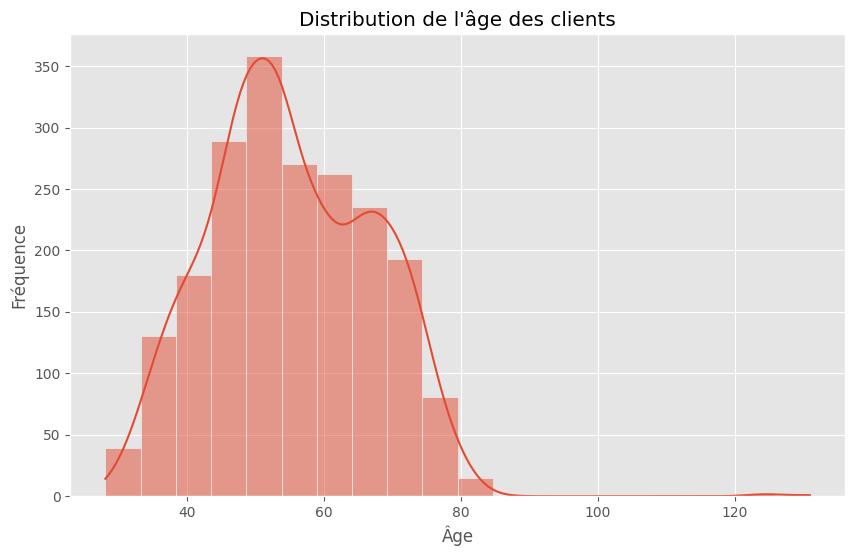

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Age'], bins=20, kde=True)
plt.title('Distribution de l\'âge des clients')
plt.xlabel('Âge')
plt.ylabel('Fréquence')
plt.show()

* **Répartition des statuts matrimoniaux**

* *Diagramme en barres*

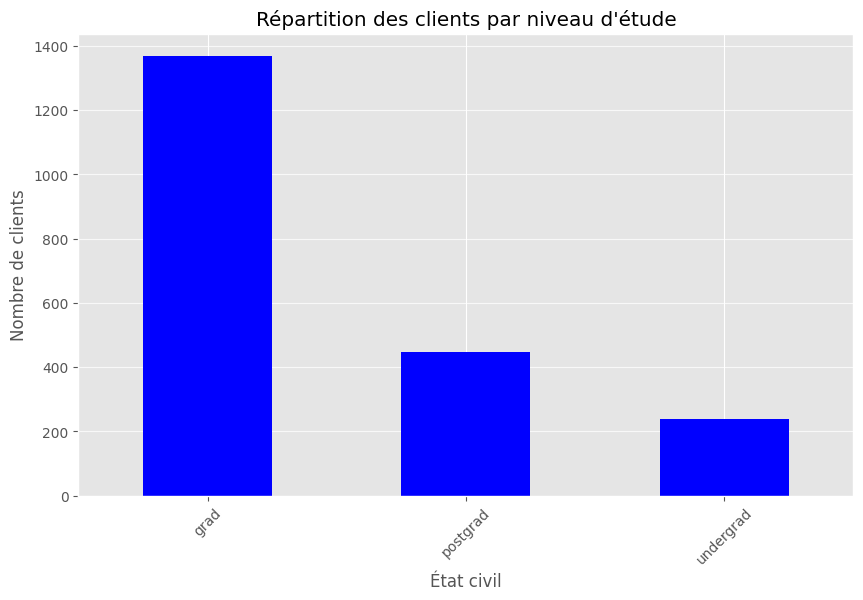

In [6]:
state_civil_counts = data['education2'].value_counts()
plt.figure(figsize=(10, 6))
state_civil_counts.plot(kind='bar', color='blue')
plt.title('Répartition des clients par niveau d\'étude')
plt.xlabel('État civil')
plt.ylabel('Nombre de clients')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()

* **Dépenses par catégorie de produit**

* *Boxplot des dépenses*

*  ***1. depenses par catégorie de produit***

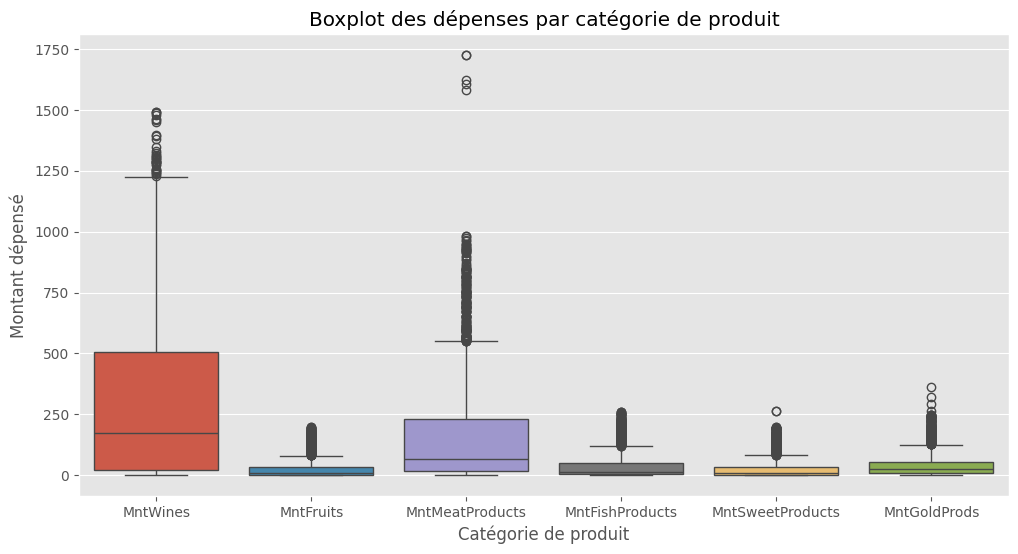

In [7]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']])
plt.title('Boxplot des dépenses par catégorie de produit')
plt.xlabel('Catégorie de produit')
plt.ylabel('Montant dépensé')
plt.show()

*  ***2. depenses totales***

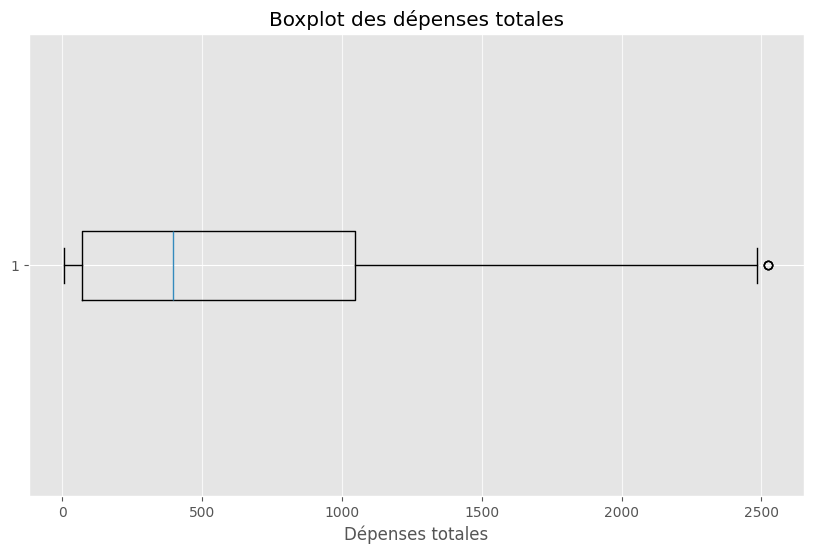

In [8]:
plt.figure(figsize=(10, 6))
plt.boxplot(data['Total_Spent'], vert=False)
plt.title('Boxplot des dépenses totales')
plt.xlabel('Dépenses totales')
plt.grid(axis='x', alpha=0.75)
plt.show()

* **Education et dépenses**

* ***graphique à barres montrant les dépenses moyennes par niveau d'éducation***

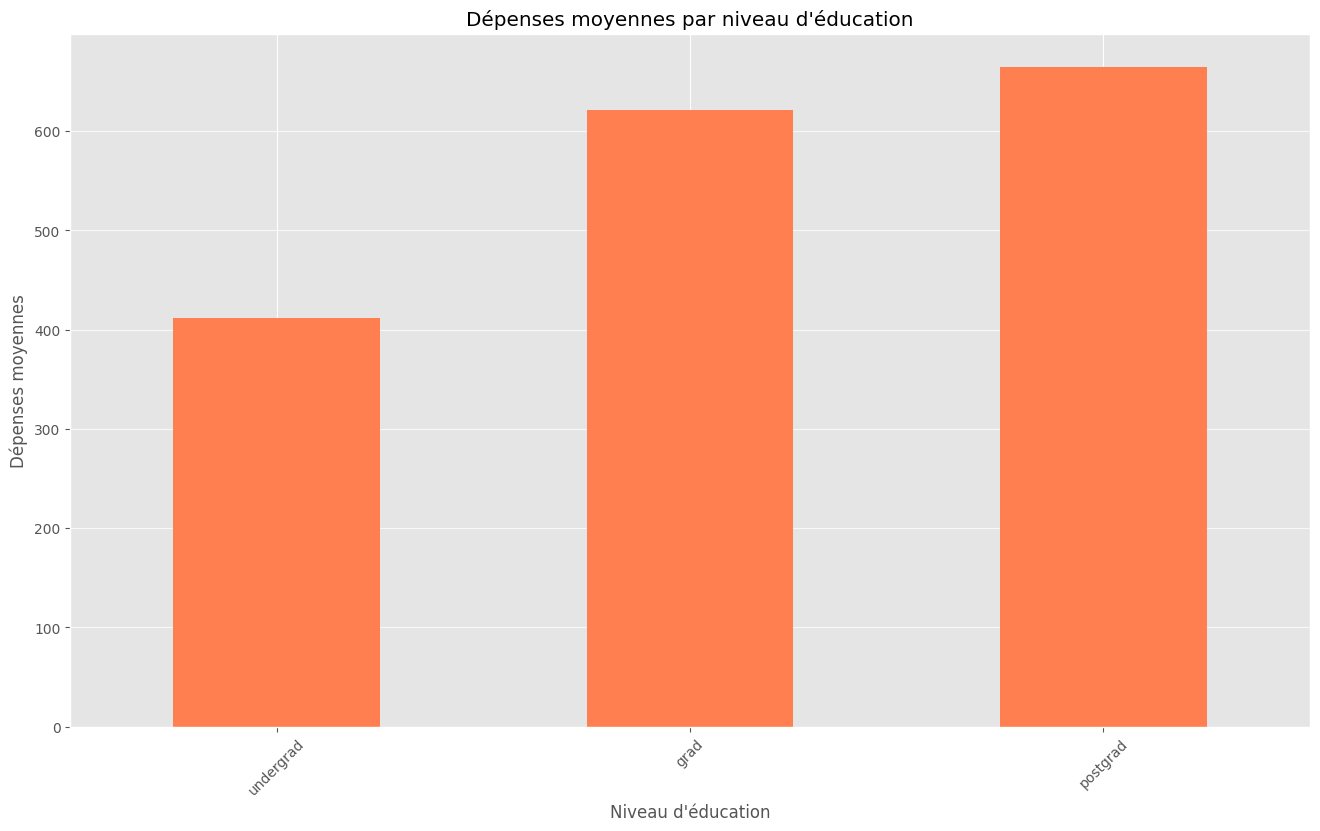

In [9]:
education_expenses = data.groupby('education2')['Total_Spent'].mean().sort_values()
plt.figure(figsize=(16, 9))
education_expenses.plot(kind='bar', color='coral')
plt.title('Dépenses moyennes par niveau d\'éducation')
plt.xlabel('Niveau d\'éducation')
plt.ylabel('Dépenses moyennes')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()

## **Interprétation**

* ***Âge*** : L'histogramme montre la distribution de l'âge des clients, ce qui peut révéler des segments d'âge prédominants.
* ***Statut matrimonial*** : Le diagramme en barres permet de voir quel statut matrimonial est le plus répandu, utile pour le ciblage marketing.
* ***Dépenses par catégories de produits*** : Le boxplot des dépenses montre les variations de dépenses entre les catégories de produits, aidant à identifier les produits les plus populaires.
* ***Dépenses totales*** : Le boxplot montre la médiane des dépenses, ainsi que les valeurs aberrantes. Cela aide à identifier les clients qui dépensent de manière significative plus que la moyenne.
* ***Éducation et Dépenses*** : Ce graphique permet d'observer si un niveau d'éducation plus élevé est associé à des dépenses plus élevées

# Analyse Exploratoire des Données (EDA)

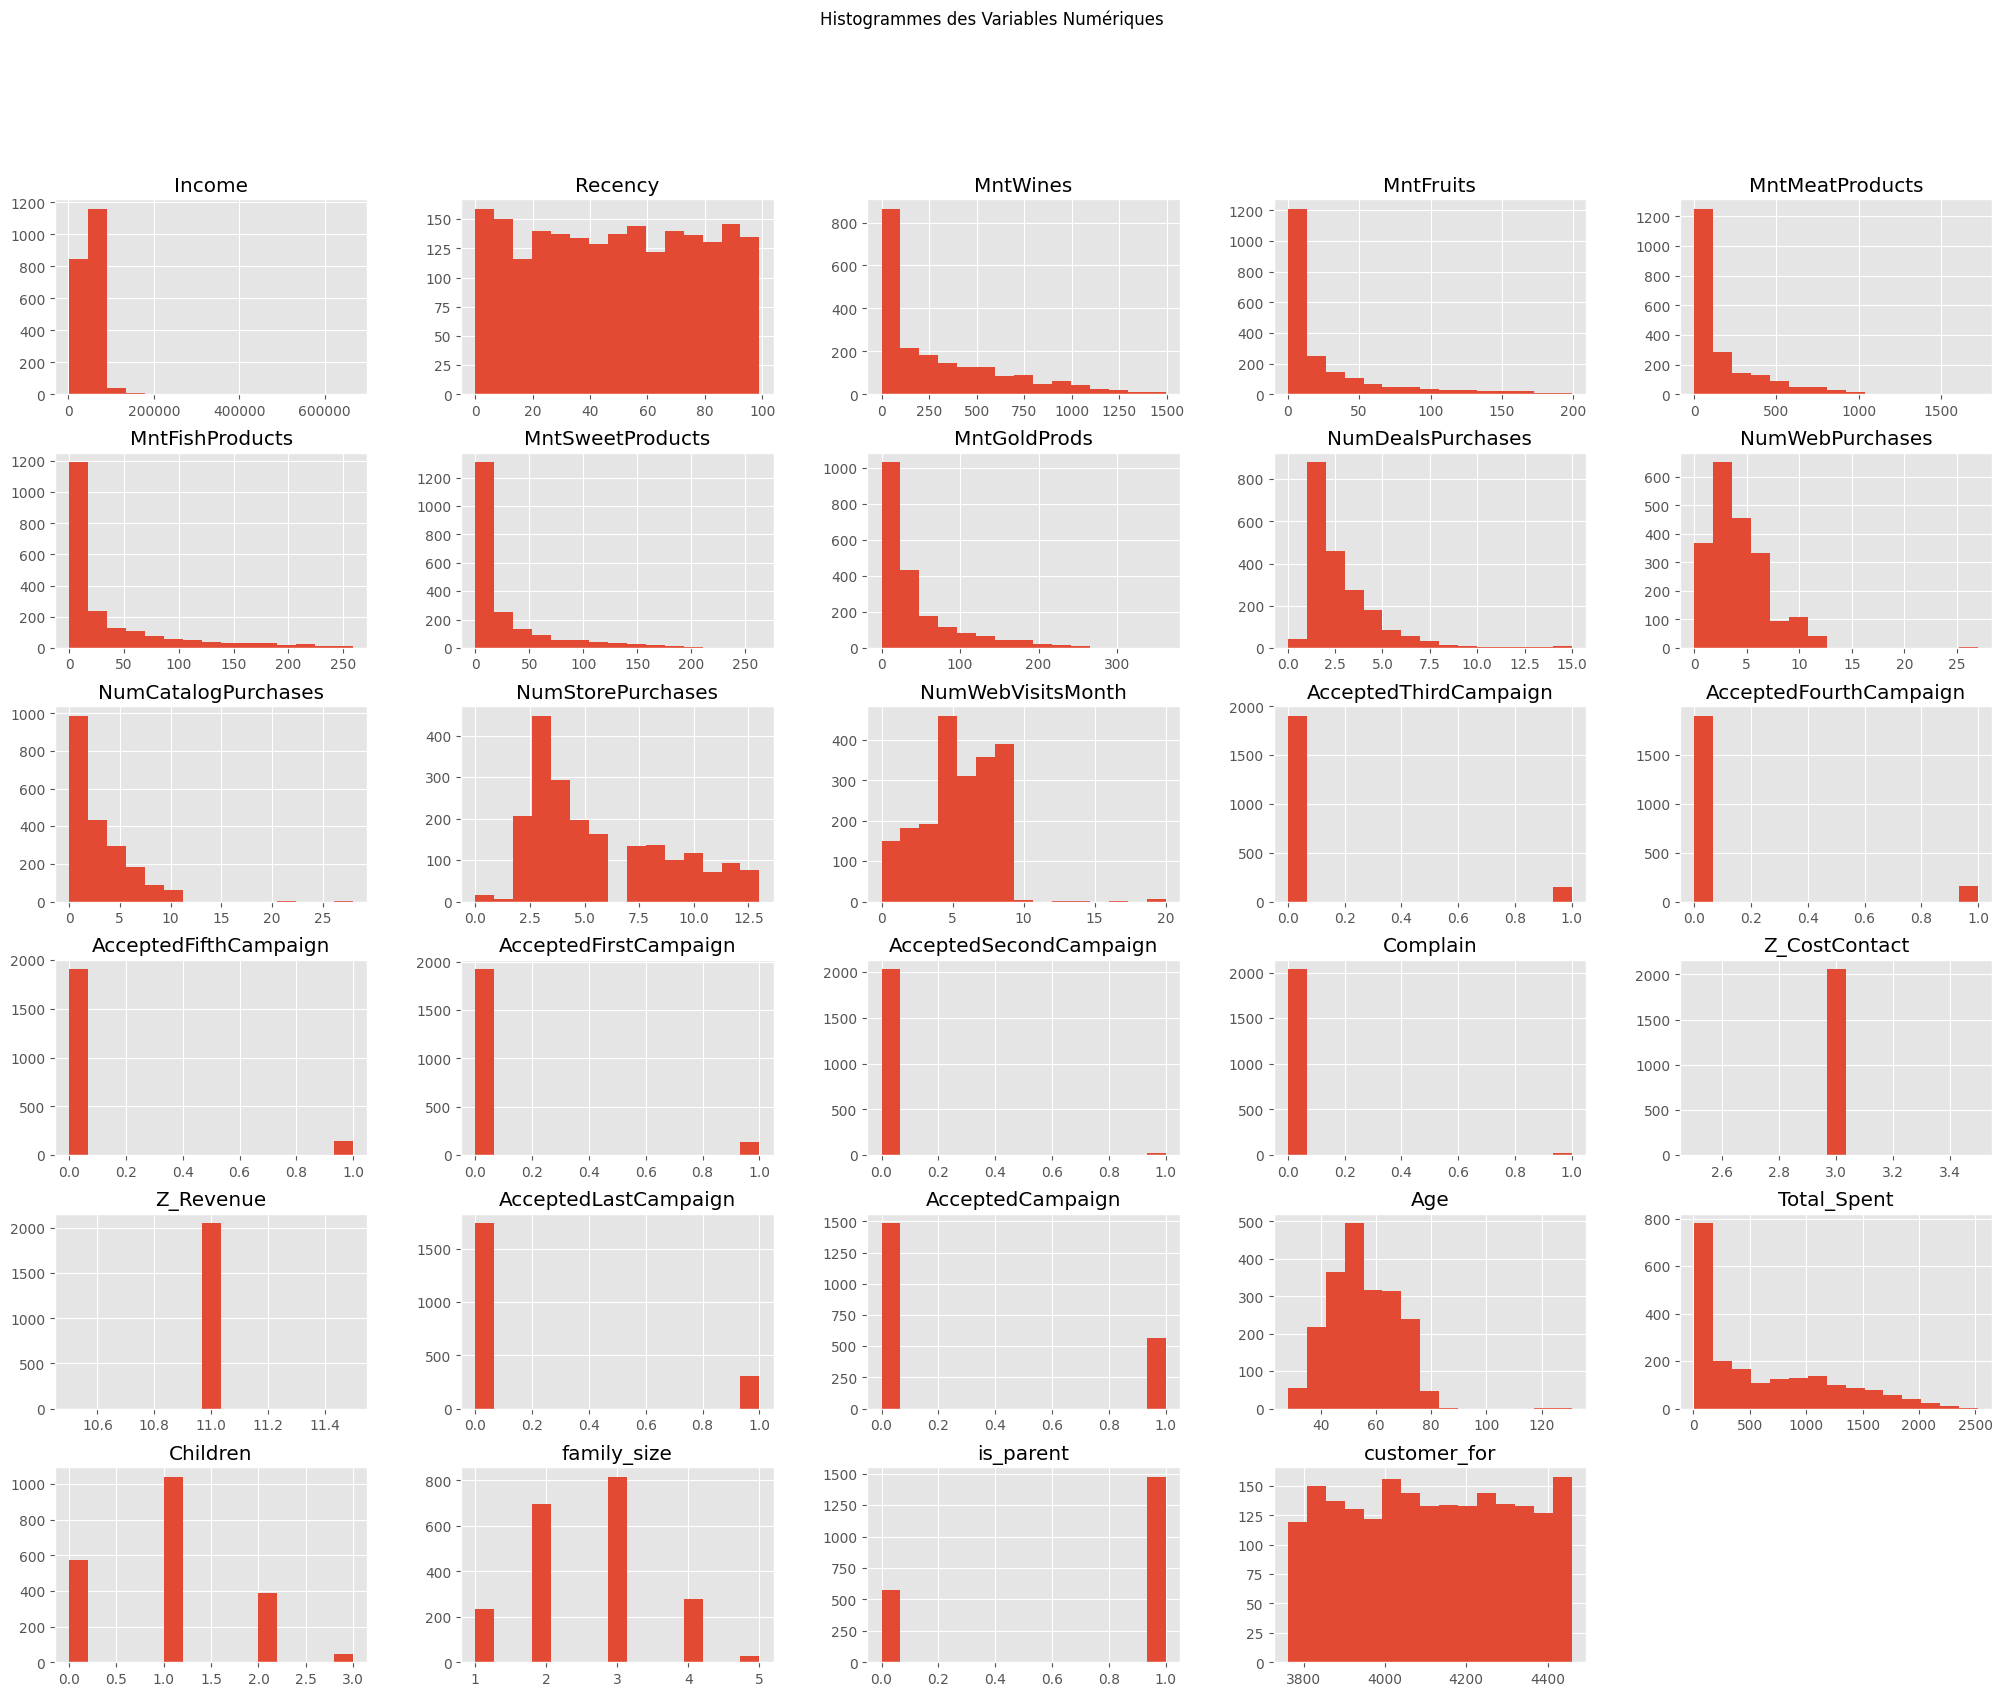

In [10]:
# Visualisation des données : histogrammes
data.hist(bins=15, figsize=(25, 19))
plt.suptitle('Histogrammes des Variables Numériques')
plt.show()


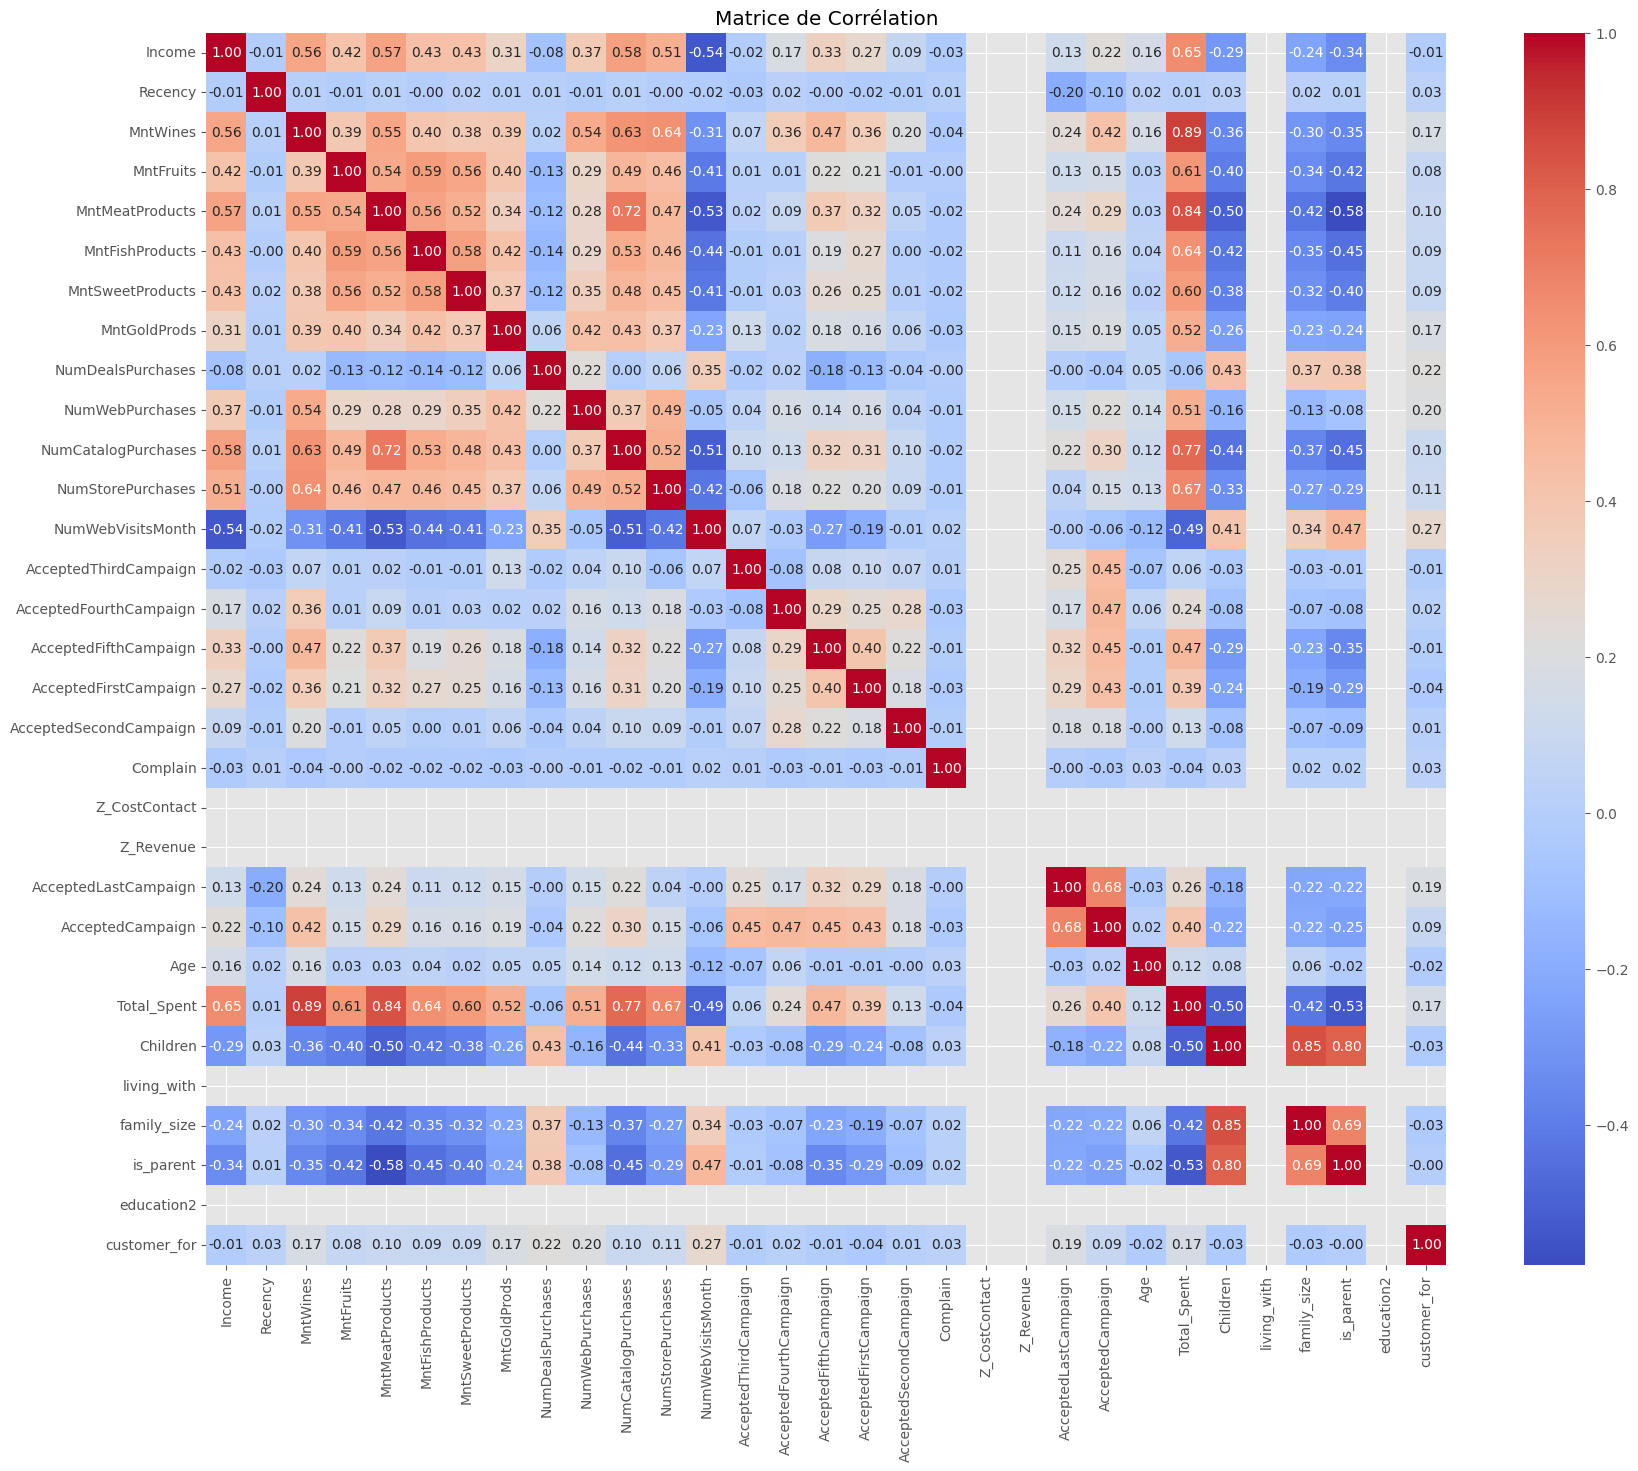

In [11]:
# Analyse des corrélations
correlation_matrix = data.apply(pd.to_numeric, errors='coerce').corr()
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matrice de Corrélation')
plt.show()

In [12]:

# Grouping et aggregation
summary = data.groupby('living_with').agg({
    'Total_Spent': 'mean',
    'NumWebPurchases': 'sum'
}).reset_index()
print("\nRésumé par statut familial :")
print(summary)


Résumé par statut familial :
  living_with  Total_Spent  NumWebPurchases
0      couple   599.101064             5387
1      single   620.654939             3037


#  Choix des KPIs

In [13]:
# Taux d'acceptation des campagnes
acceptance_rate = data[['AcceptedCampaign', 'AcceptedFirstCampaign', 'AcceptedSecondCampaign',
                         'AcceptedThirdCampaign', 'AcceptedFourthCampaign', 'AcceptedFifthCampaign']].mean()
print("\nTaux d'acceptation des campagnes :")
print(acceptance_rate*100)

# Dépenses moyennes par client
average_spending = data['Total_Spent'].mean()
print("\nDépenses moyennes par client :", average_spending)

# Fréquence d'achat
purchase_frequency = data[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum().sum() / len(data)
print("\nFréquence d'achat :", purchase_frequency)

# Recency
average_recency = data['Recency'].mean()
print("\nRecency moyenne :", average_recency)

# Churn Rate
churn_rate = 1 - acceptance_rate.mean()
print("\nChurn Rate :", churn_rate*100 , "%")


Taux d'acceptation des campagnes :
AcceptedCampaign          27.591241
AcceptedFirstCampaign      6.569343
AcceptedSecondCampaign     1.265207
AcceptedThirdCampaign      7.299270
AcceptedFourthCampaign     7.688564
AcceptedFifthCampaign      7.201946
dtype: float64

Dépenses moyennes par client : 606.8520681265206

Fréquence d'achat : 12.53625304136253

Recency moyenne : 48.99805352798054

Churn Rate : 90.39740470397405 %


# Feature Engineering

In [14]:
# Initialiser le LabelEncoder
label_encoder = LabelEncoder()

# Ré-encodage des variables catégorielles
label_encoder = LabelEncoder()
categorical_vars = ['living_with', 'education2']
for var in categorical_vars:
    if var in data.columns:
        data[var] = label_encoder.fit_transform(data[var])

# Afficher les premières lignes pour vérifier le ré-encodage
print(data[categorical_vars].head())

   living_with  education2
0            1           0
1            1           0
2            0           0
3            0           0
4            0           1


In [15]:
# Suppression des caractéristiques liées aux promotions
promo_columns = ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
                 'NumStorePurchases', 'AcceptedFirstCampaign', 'AcceptedSecondCampaign',
                 'AcceptedThirdCampaign', 'AcceptedFourthCampaign',
                 'AcceptedFifthCampaign', 'AcceptedLastCampaign']
data_filtered = data.drop(columns=promo_columns, errors='ignore')

In [16]:
# Sélection des features
X = data_filtered.drop(columns=['AcceptedCampaign','Dt_Customer'], errors='ignore')
y =  data_filtered['AcceptedCampaign']

# Vérification des types de données
print("Types de données avant le scaling :")
print(X.dtypes)

Types de données avant le scaling :
Income               float64
Recency                int64
MntWines               int64
MntFruits              int64
MntMeatProducts        int64
MntFishProducts        int64
MntSweetProducts       int64
MntGoldProds           int64
NumWebVisitsMonth      int64
Complain               int64
Z_CostContact          int64
Z_Revenue              int64
Age                    int64
Total_Spent            int64
Children               int64
living_with            int64
family_size            int64
is_parent              int64
education2             int64
customer_for           int64
dtype: object


In [17]:
# Vérification des colonnes
print("Colonnes disponibles dans le jeu de données :")
print(data.columns)

Colonnes disponibles dans le jeu de données :
Index(['Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedThirdCampaign',
       'AcceptedFourthCampaign', 'AcceptedFifthCampaign',
       'AcceptedFirstCampaign', 'AcceptedSecondCampaign', 'Complain',
       'Z_CostContact', 'Z_Revenue', 'AcceptedLastCampaign',
       'AcceptedCampaign', 'Age', 'Total_Spent', 'Children', 'living_with',
       'family_size', 'is_parent', 'education2', 'customer_for'],
      dtype='object')


In [18]:
# On garde uniquement les colonnes numériques
X_numeric = X.select_dtypes(include=['float64', 'int64'])

# Vérification des dimensions après filtrage
print("Dimensions des données après filtrage :")
print(X_numeric.shape)

Dimensions des données après filtrage :
(2055, 20)


In [19]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
# Application de la régression logistique
model = LogisticRegression()

# Entraîner le modèle
model.fit(X_train, y_train)

LogisticRegression()

In [21]:
# Prédictions sur l'ensemble de test
y_test_pred = model.predict(X_test)
y_train_pred= model.predict(X_train)

In [22]:
# Évaluation du modèle
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_test_pred))
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Accuracy Train: {accuracy_train * 100:.2f}%')
print(f'Accuracy Test: {accuracy_test * 100:.2f}%')


# Réintégrer le modèle de régression logistique avant la validation croisée
model = LogisticRegression()
cv_scores = cross_val_score(model, X_scaled, data['AcceptedCampaign'], cv=5)
print(f'Scores validés par croisement: {cv_scores}')
print(f'Score moyen validé en croix: {cv_scores.mean()*100}%')

Matrice de confusion :
[[281  17]
 [ 76  37]]
Accuracy Train: 78.95%
Accuracy Test: 77.37%
Scores validés par croisement: [0.75425791 0.77615572 0.7810219  0.79075426 0.80291971]
Score moyen validé en croix: 78.1021897810219%


In [23]:
# Continuer avec l'ajustement du modèle
X_train_sm = sm.add_constant(X_train)  # Ajouter une constante pour l'interception
model_sm = sm.Logit(y_train, X_train_sm)

# Essayer d'ajuster avec method='bfgs' pour gérer la singularité
try:
    result = model_sm.fit(method='bfgs')  # Use 'bfgs' optimizer
except np.linalg.LinAlgError:
    print("Using 'bfgs' a échoué. Essai d'un solveur alternatif.")
    result = model_sm.fit_regularized(method='l1')  # Try L1 regularization

print(result.summary())

         Current function value: 0.468833
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                           Logit Regression Results                           
Dep. Variable:       AcceptedCampaign   No. Observations:                 1644
Model:                          Logit   Df Residuals:                     1627
Method:                           MLE   Df Model:                           16
Date:                Mon, 18 Nov 2024   Pseudo R-squ.:                  0.2044
Time:                        12:49:08   Log-Likelihood:                -770.76
converged:                      False   LL-Null:                       -968.79
Covariance Type:            nonrobust   LLR p-value:                 2.451e-74
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1859        nan        nan        nan         nan         n

In [24]:
# Créer le modèle de régression logistique
model = LogisticRegression()
# Entraîner le modèle
model.fit(X_train, y_train)

LogisticRegression()

In [25]:
# Prédictions sur l'ensemble d'entraînement et de test
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [26]:
# Évaluation du modèle
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_test_pred))
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Accuracy Train: {accuracy_train * 100:.2f}%')
print(f'Accuracy Test: {accuracy_test * 100:.2f}%')

Matrice de confusion :
[[281  17]
 [ 76  37]]
Accuracy Train: 78.95%
Accuracy Test: 77.37%


In [27]:
print("\nRapport de classification :")
print(classification_report(y_test, y_test_pred))


Rapport de classification :
              precision    recall  f1-score   support

           0       0.79      0.94      0.86       298
           1       0.69      0.33      0.44       113

    accuracy                           0.77       411
   macro avg       0.74      0.64      0.65       411
weighted avg       0.76      0.77      0.74       411



***a. Ré-encodage des Variables Catégorielles***:
* Les algorithmes de machine learning nécessitent des entrées numériques. Le LabelEncoder convertit les catégories en valeurs numériques, ce qui permet aux modèles de traiter ces variables sans confusion.
* Cela aide également à réduire la dimensionnalité lorsque plusieurs catégories sont présentes, tout en maintenant l'intégrité des données.

***b. Scaling des Données***:
* Le scaling est essentiel lorsque les caractéristiques ont des échelles différentes. Par exemple, des revenus en milliers et des âges en années peuvent mener à des biais dans les modèles.

* StandardScaler standardise les variables pour qu'elles aient une moyenne de 0 et un écart-type de 1. Cela permet d'améliorer la convergence des algorithmes d'apprentissage, surtout pour ceux basés sur la distance (comme KNN ou SVM).

* Un bon scaling permet également d'améliorer la performance des modèles et d'assurer une meilleure interprétabilité des résultats.

In [28]:
# Création d'un DataFrame pour la comparaison
results_df = pd.DataFrame(X_test, columns=X.columns)
results_df['Actual'] = y_test.values
results_df['Predicted'] = y_test_pred

# Afficher les premières lignes pour vérification
print(results_df.head())

     Income   Recency  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0  1.089372 -0.530662  1.321289   3.317842         1.957278         0.456682   
1 -1.397738  0.880111 -0.813099  -0.597401        -0.539327        -0.343748   
2  1.145475  1.258611  3.370184   1.547254        -0.046917         0.565831   
3  0.730483 -1.425298  1.610198   0.824057         0.151775         0.729556   
4 -0.235891  1.533883 -0.359099  -0.622339        -0.660269        -0.543855   

   MntSweetProducts  MntGoldProds  NumWebVisitsMonth  Complain  ...       Age  \
0          0.096999      0.064560          -0.936378 -0.092677  ... -1.530850   
1         -0.162565     -0.049137           1.064409 -0.092677  ...  0.487098   
2          0.167790      1.182578           0.264094 -0.092677  ...  1.159747   
3          0.191387      0.064560          -0.136063 -0.092677  ... -0.774119   
4         -0.469323     -0.769217          -0.136063 -0.092677  ...  0.739341   

   Total_Spent  Children  living

In [29]:
# Compter le nombre de campagnes acceptées et refusées prédites
campaign_counts = results_df['Predicted'].value_counts()

# Calculer le total des clients
total_clients = campaign_counts.sum()

# Calculer les taux d'acceptation et de refus
accept_rate = (campaign_counts.get(1, 0) / total_clients) * 100  # Taux d'acceptation
refuse_rate = (campaign_counts.get(0, 0) / total_clients) * 100    # Taux de refus

# Afficher les résultats
print("Nombre de campagnes acceptées et refusées prédites :")
print(campaign_counts)

print(f"\nTaux d'acceptation : {accept_rate:.2f}%")
print(f"Taux de refus : {refuse_rate:.2f}%")

Nombre de campagnes acceptées et refusées prédites :
Predicted
0    357
1     54
Name: count, dtype: int64

Taux d'acceptation : 13.14%
Taux de refus : 86.86%


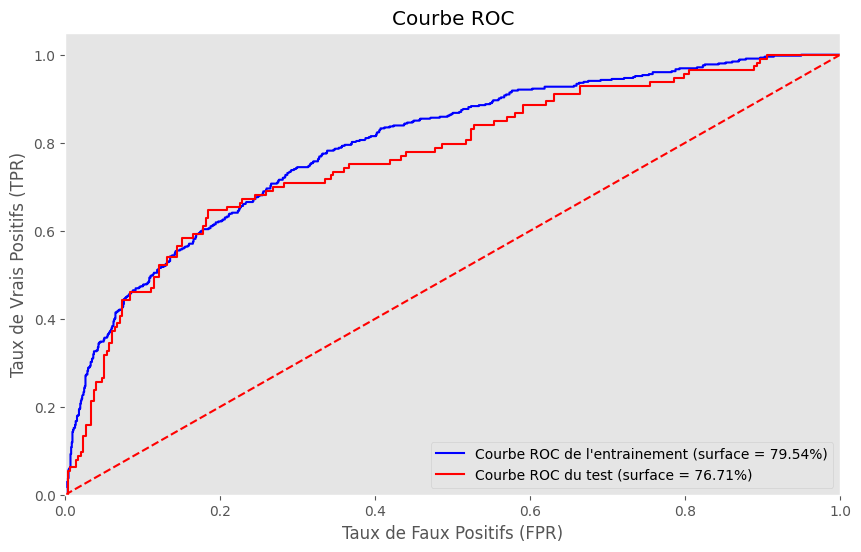

In [30]:
# Prédictions des probabilités
y_test_prob = model.predict_proba(X_test)[:, 1] # Probabilités pour la classe positive
y_train_prob =  model.predict_proba(X_train)[:, 1] # Probabilités pour la classe positive

# Calcul de la courbe ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test,tpr_test)
auc_train = roc_auc_score(y_train, y_train_prob)*100
auc_test = roc_auc_score(y_test, y_test_prob)*100
# Tracer la courbe ROC
plt.figure(figsize=(10,6))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Courbe ROC de l\'entrainement (surface = {auc_train:.2f}%)')
plt.plot(fpr_test, tpr_test, color='red', label=f'Courbe ROC du test (surface = {auc_test:.2f}%)')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # ligne diagonale
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

#  Clustering Client

In [31]:
# Réduction de dimensionnalité avec PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
# Diviser les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le modèle
model.fit(X_train, y_train)

# Prédire
y_pred = model.predict(X_test)

# Évaluation du modèle
print(classification_report(y_test, y_pred))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

# Calculer et afficher l'accuracy
accuracy = accuracy_score(y_test, y_pred)*100
print(f"Accuracy du modèle : {accuracy:.2f}%")

              precision    recall  f1-score   support

           0       0.78      0.93      0.85       298
           1       0.64      0.33      0.43       113

    accuracy                           0.76       411
   macro avg       0.71      0.63      0.64       411
weighted avg       0.74      0.76      0.74       411

Matrice de confusion :
[[277  21]
 [ 76  37]]
Accuracy du modèle : 76.40%


In [32]:
# Testez la robustesse en utilisant un autre échantillon
X_train, X_test, y_train, y_test = train_test_split(X_scaled, data['AcceptedFirstCampaign'], test_size=0.3, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Évaluation
print(f'Test de robustesse Précision: {accuracy_score(y_test, y_pred)*100}%')

Test de robustesse Précision: 94.81361426256078%


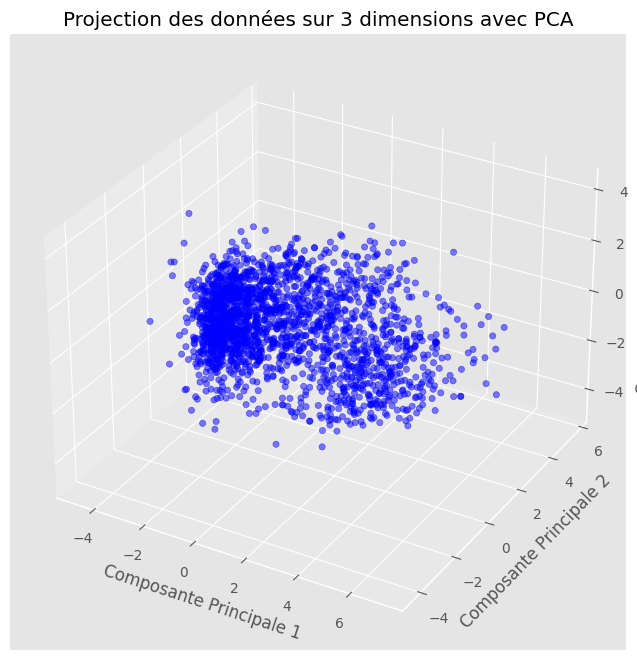

In [33]:
# Visualisation de la projection des données sur 3 dimensions
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c='blue', marker='o', alpha=0.5)
ax.set_title('Projection des données sur 3 dimensions avec PCA')
ax.set_xlabel('Composante Principale 1')
ax.set_ylabel('Composante Principale 2')
ax.set_zlabel('Composante Principale 3')
plt.show()

* ***2. Choisir une méthode de clustering : Tester K-means et Agglomerative Clustering.***
* ***Visualisation des clusters : Afficher les résultats dans un graphique 3D.***

* ***a. Méthode de clustering : K-means***

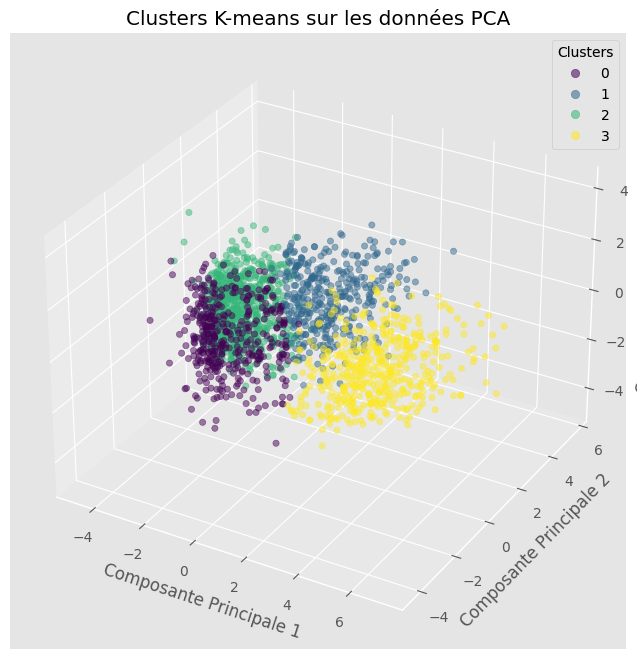

In [34]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)
# Visualisation des clusters K-means
fig_kmeans = plt.figure(figsize=(10, 8))
ax_kmeans = fig_kmeans.add_subplot(111, projection='3d')
scatter_kmeans = ax_kmeans.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=kmeans_labels, marker='o', alpha=0.5)
legend1 = ax_kmeans.legend(*scatter_kmeans.legend_elements(), title="Clusters")
ax_kmeans.add_artist(legend1)

ax_kmeans.set_title('Clusters K-means sur les données PCA')
ax_kmeans.set_xlabel('Composante Principale 1')
ax_kmeans.set_ylabel('Composante Principale 2')
ax_kmeans.set_zlabel('Composante Principale 3')
plt.show()


Silhouette Score : 0.5438453377300096


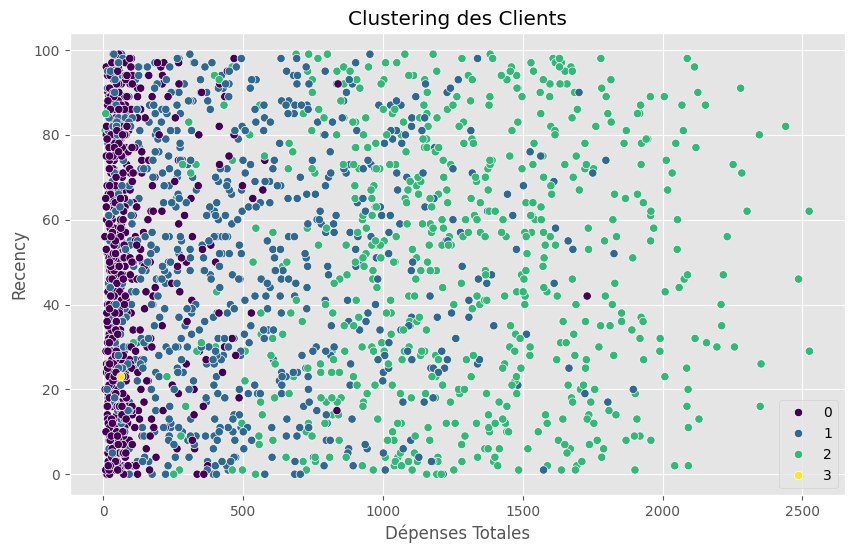

In [35]:
# Choisir le nombre de clusters
kmeans = KMeans(n_clusters=4, random_state=42)
data['Cluster'] = kmeans.fit_predict(X)

# Évaluation des clusters
silhouette_avg = silhouette_score(X, data['Cluster'])
print("\nSilhouette Score :", silhouette_avg)

# Visualisation des clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['Total_Spent'], y=data['Recency'], hue=data['Cluster'], palette='viridis')
plt.title('Clustering des Clients')
plt.xlabel('Dépenses Totales')
plt.ylabel('Recency')
plt.legend()
plt.show()

# Interprétation des Résultats

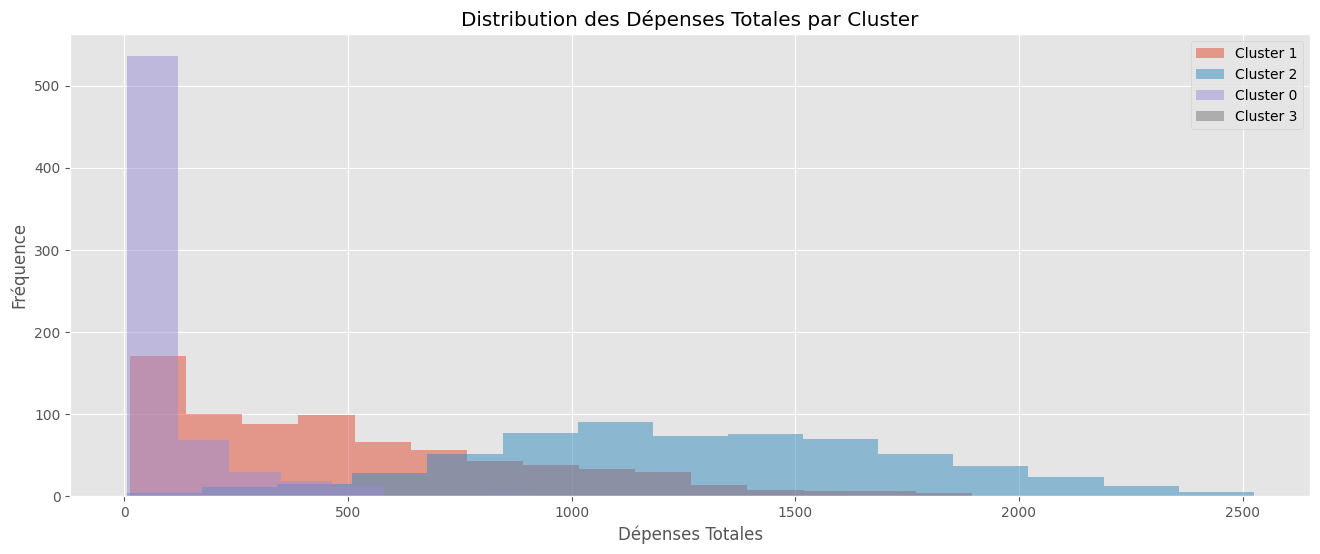


Recommandations pour chaque segment :
Cluster 1: Stratégies de marketing ciblées.
Cluster 2: Stratégies de marketing ciblées.
Cluster 0: Stratégies de marketing ciblées.
Cluster 3: Stratégies de marketing ciblées.


In [36]:
# Visualisation des segments
for cluster in data['Cluster'].unique():
    cluster_data = data[data['Cluster'] == cluster]
    plt.hist(cluster_data['Total_Spent'], bins=15, alpha=0.5, label=f'Cluster {cluster}')
plt.title('Distribution des Dépenses Totales par Cluster')
plt.xlabel('Dépenses Totales')
plt.ylabel('Fréquence')
plt.legend()
plt.show()

# Recommandations
print("\nRecommandations pour chaque segment :")
for cluster in data['Cluster'].unique():
    print(f"Cluster {cluster}: Stratégies de marketing ciblées.")

# Évaluation des modèles et interprétation du profil consommateur

* ***1.Répartition des Clients par Clusters***

In [37]:
# Compter le nombre de clients dans chaque cluster
cluster_counts = pd.Series(kmeans_labels).value_counts(normalize=True) * 100
print("Répartition des clients par cluster :")
print(cluster_counts)

Répartition des clients par cluster :
2    40.291971
3    21.995134
0    19.513382
1    18.199513
Name: proportion, dtype: float64


* ***2. Regroupement des Clients par Caractéristiques Croisées***

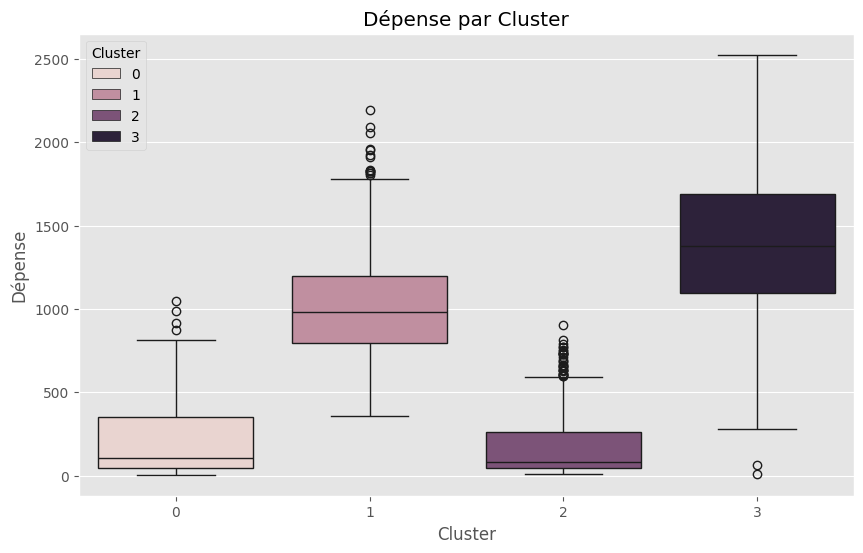

In [38]:
# Ajouter les labels des clusters au DataFrame
data_filtered['Cluster'] = kmeans_labels

# Visualisation des dépenses par revenu selon les clusters
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Total_Spent', hue='Cluster', data=data_filtered)
plt.title('Dépense par Cluster')
plt.xlabel('Cluster')
plt.ylabel('Dépense')
plt.show()

* ***3. Répartition des Clusters sur les Campagnes Passées***

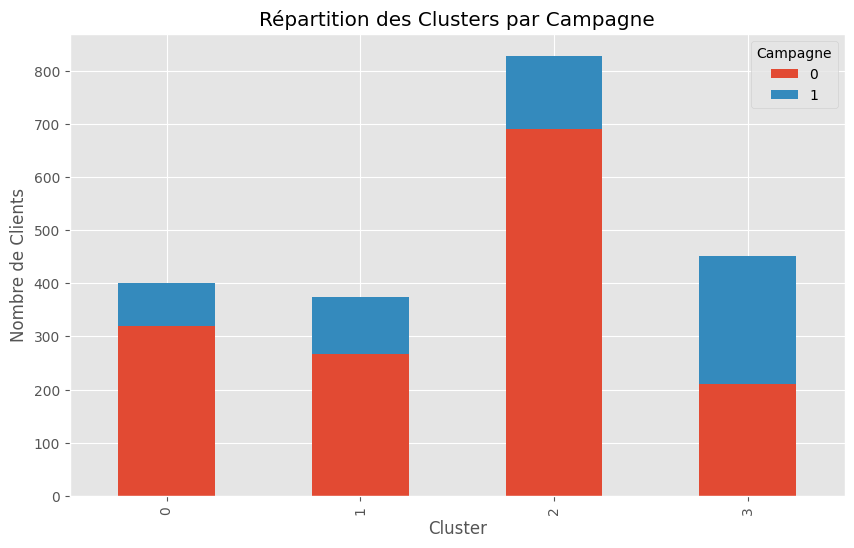

In [39]:
# Estimation de la répartition des clusters par campagne
campaign_distribution = data_filtered.groupby(['Cluster', 'AcceptedCampaign']).size().unstack()
campaign_distribution.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Répartition des Clusters par Campagne')
plt.xlabel('Cluster')
plt.ylabel('Nombre de Clients')
plt.legend(title='Campagne')
plt.show()

* ***4. Déterminants de la Dépense et Profils Consommateurs***

In [40]:
# Modèle de régression pour estimer les déterminants de la dépense
X = data_filtered[['Total_Spent', 'Age', 'education2']]  # Choisir des variables pertinentes
y = data_filtered['Total_Spent']

# Ajouter une constante pour le modèle
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Total_Spent   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.560e+32
Date:                Mon, 18 Nov 2024   Prob (F-statistic):               0.00
Time:                        12:49:12   Log-Likelihood:                 54235.
No. Observations:                2055   AIC:                        -1.085e+05
Df Residuals:                    2051   BIC:                        -1.084e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.587e-13   8.93e-14     -5.140      

In [41]:
# Supposons que 'kmeans' est votre modèle de clustering et que 'data' est votre DataFrame

# Ajoutez les clusters au DataFrame
data['Cluster'] = kmeans.labels_

# Moyennes des features par cluster
cluster_means = data.groupby('Cluster').mean()
print("\nMoyennes des Features par Cluster :")
print(cluster_means)

# Visualisation des moyennes
#plt.figure(figsize=(20, 16))
#sns.heatmap(cluster_means, annot=True, fmt=".2f", cmap="coolwarm")
#plt.title("Moyennes des Features par Cluster")
#plt.xlabel("Features")
#plt.ylabel("Clusters")
#plt.show()


Moyennes des Features par Cluster :
                Income    Recency    MntWines  MntFruits  MntMeatProducts  \
Cluster                                                                     
0         28206.401198  48.553892   30.348802   6.082335        26.007485   
1         52396.035789  49.607895  288.921053  18.886842       101.359211   
2         77159.242812  48.773163  615.442492  56.789137       400.367412   
3        666666.000000  23.000000    9.000000  14.000000        18.000000   

         MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
Cluster                                                                       
0               8.950599          6.181138     18.049401           2.163174   
1              24.801316         18.273684     45.518421           3.078947   
2              83.004792         60.531949     69.562300           1.619808   
3               8.000000          1.000000     12.000000           4.000000   

         NumWebPurchases 